# Customer Product Review: Sentiment Analysis

In [1]:
!pip install scikit-plot

In [2]:
from sklearn.svm import LinearSVC
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score,classification_report
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import numpy as np
import scipy
import scipy.interpolate

# Patch missing interp references
scipy.interp = np.interp
scipy.interpolate.interp = np.interp

import scikitplot as skplt

import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [4]:
import pandas as pd

file_path = "/content/gdrive/My Drive/Projects /245_1.csv"
dataset = pd.read_csv(file_path)

print(dataset.head())


                     id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                          categories             dateAdded  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Mo...  2017-07-25T00:52:42Z   
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...  2017-07-25T05:16:03Z   
2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...  2017-07-25T05:16:03Z   
3  Personal Care,Medicine Cabinet,Lubricant/Sperm...  2017-07-25T16:26:19Z   
4  Personal Care,Medicine Cabinet,Lubricant/Sperm...  2017-07-25T16:26:19Z   

            dateUpdated          ean  \
0  2018-02-05T08:36:58Z  6.02537E+11   
1  2018-02-05T11:27:45Z  73416000391   
2  2018-02-05T11:27:45Z  73416000391   
3  2018-02-05T11:25:51Z  67981934427   
4  2018-02-05T11:25:51Z  67981934427   

                         

In [5]:
dataset.shape

(71044, 25)

In [6]:
dataset.isnull().sum()


,0
id,0
brand,0
categories,0
dateAdded,0
dateUpdated,0
ean,31979
keys,0
manufacturer,141
manufacturerNumber,203
name,0


# Data Cleaning:

Selecting Required Columns:

In [7]:
dataset = dataset[['brand','manufacturer','reviews.didPurchase','reviews.rating', 'reviews.text']]

Checking Null values:

In [8]:

dataset.isnull().sum()

,0
brand,0
manufacturer,141
reviews.didPurchase,38886
reviews.rating,0
reviews.text,36


Inputing null values on 'reviews.didpurchase' & Removing all the null values:

In [9]:
dataset['reviews.didPurchase'] = dataset['reviews.didPurchase'].fillna('Not Avialable')

In [10]:
dataset = dataset.dropna()

# Visualizing The Result:


 Review Ratings Distribution:

In [11]:
data = dataset['reviews.rating'].value_counts()


<Axes: xlabel='reviews.rating'>

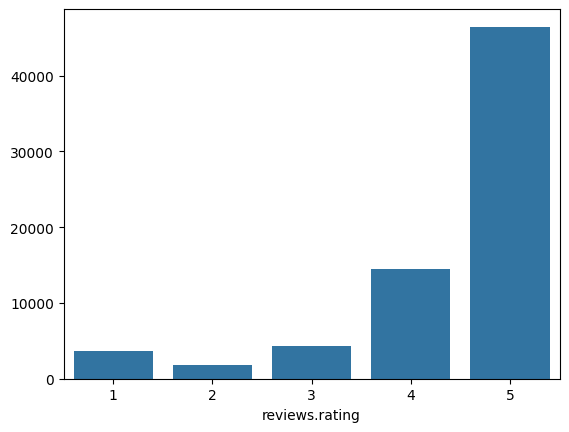

In [12]:
sns.barplot(x=data.index, y=data.values)

*Need to map 1,2 - Unhappy, 3-OK and 4,5 - Happy*

Fake Reviews Provided by User:

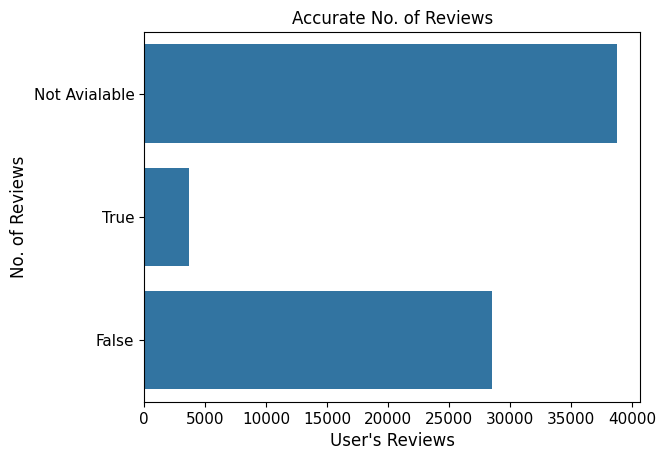

In [13]:
ax_plt = sns.countplot(dataset['reviews.didPurchase'])
ax_plt.set_xlabel(xlabel="User's Reviews",fontsize=12)
ax_plt.set_ylabel(ylabel='No. of Reviews',fontsize=12)
ax_plt.axes.set_title('Accurate No. of Reviews',fontsize=12)
ax_plt.tick_params(labelsize=11)


*True reviews are less in number and as you can see poeple who didn't even purchase the product has provided reviews these are all fake reviews which are much higher than those who have purchased and provided the review.*

**Wordcloud**

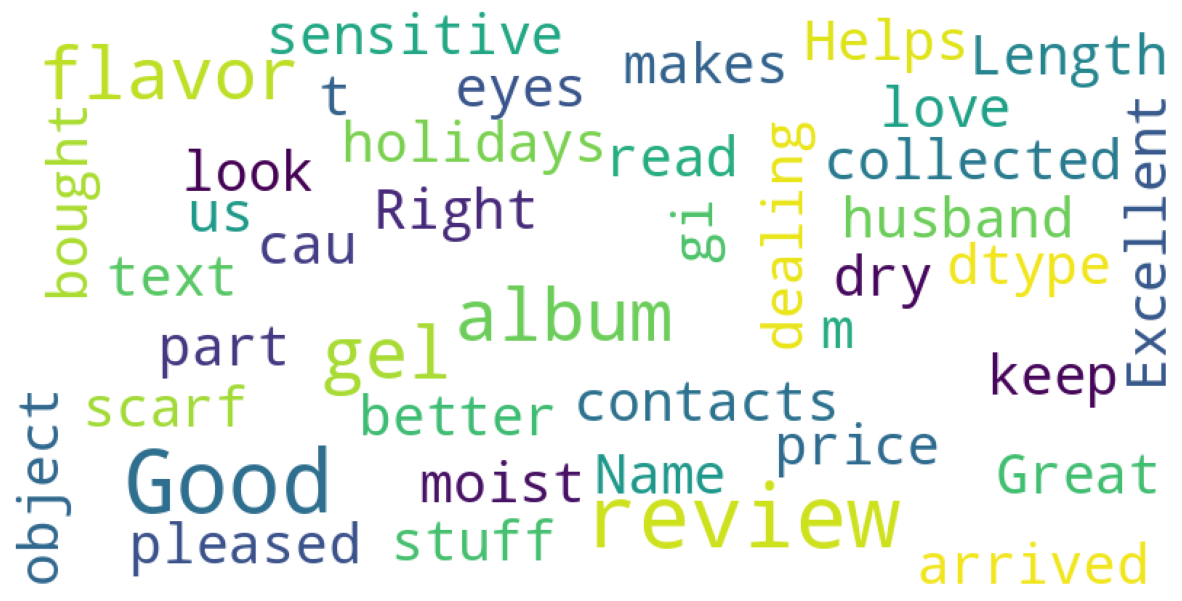

In [14]:
stopwords = set(STOPWORDS)
def wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=250,
        max_font_size=30,
        scale=2,
        random_state=5 #chosen a andom by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

wordcloud(dataset['reviews.text'])

# Feature Transformation:

In [15]:
data=dataset['reviews.text']
train_data=dataset['reviews.text']
y_target=dataset['reviews.rating'].map({1:'Unhappy',2:'Unhappy',3:'Ok',4:'Happy',5:'Happy'})

In [16]:
vectorize_word = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',stop_words='english',ngram_range=(1, 1),max_features=10000)
vectorize_word.fit(data)
train_features_word = vectorize_word.transform(train_data)

In [17]:
vectorize_char = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='char',stop_words='english',ngram_range=(2, 6),max_features=50000)
vectorize_char.fit(data)
train_features_char = vectorize_char.transform(train_data)
train_features = hstack([train_features_char, train_features_word])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_features, y_target,test_size=0.3,random_state=101,shuffle=True)


# Logistic Regression Model:

In [19]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model
logreg = LogisticRegression(class_weight='balanced', solver='liblinear') # Using liblinear solver for smaller datasets and it's good for L1/L2 regularization
logreg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', solver='liblinear')

In [20]:
# Predict on the training set
pred_train_logreg = logreg.predict(X_train)
print("Accuracy Train (Logistic Regression): {}".format(accuracy_score(y_train, pred_train_logreg)))
print("Classification Report Train (Logistic Regression):\n", classification_report(y_train, pred_train_logreg))



Accuracy Train (Logistic Regression): 0.9485546103293956
Classification Report Train (Logistic Regression):
               precision    recall  f1-score   support

       Happy       0.98      0.97      0.97     42745
          Ok       0.67      0.73      0.70      3014
     Unhappy       0.85      0.91      0.88      3847

    accuracy                           0.95     49606
   macro avg       0.83      0.87      0.85     49606
weighted avg       0.95      0.95      0.95     49606



In [21]:
# Predict on the test set
pred_test_logreg = logreg.predict(X_test)
print("Accuracy Test (Logistic Regression): {}".format(accuracy_score(y_test, pred_test_logreg)))
print("Classification Report Test (Logistic Regression):\n", classification_report(y_test, pred_test_logreg))



Accuracy Test (Logistic Regression): 0.9013687032594893
Classification Report Test (Logistic Regression):
               precision    recall  f1-score   support

       Happy       0.95      0.95      0.95     18243
          Ok       0.40      0.38      0.39      1336
     Unhappy       0.72      0.76      0.74      1682

    accuracy                           0.90     21261
   macro avg       0.69      0.70      0.69     21261
weighted avg       0.90      0.90      0.90     21261



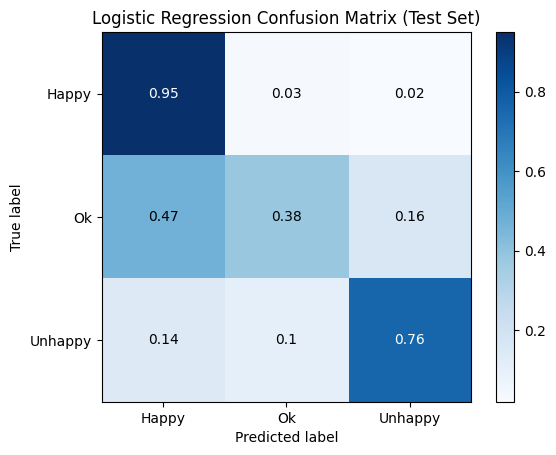

In [22]:
# Plot confusion matrix for the test set
skplt.metrics.plot_confusion_matrix(y_test, pred_test_logreg, normalize=True)
plt.title("Logistic Regression Confusion Matrix (Test Set)")
plt.show()

# SVC Model:

In [23]:
lsvm = LinearSVC(class_weight='balanced')
l = lsvm.fit(X_train,y_train)

 Linear SVC Metric Over Training:

In [24]:
pred_train = l.predict(X_train)

In [25]:
print("Accuracy Train: {}".format(accuracy_score(y_train,pred_train)))
print(classification_report(y_train,pred_train))

Accuracy Train: 0.9886908841672378
              precision    recall  f1-score   support

       Happy       1.00      0.99      0.99     42745
          Ok       0.89      0.97      0.93      3014
     Unhappy       0.98      1.00      0.99      3847

    accuracy                           0.99     49606
   macro avg       0.95      0.99      0.97     49606
weighted avg       0.99      0.99      0.99     49606



Linear SVC Metric Over Test:

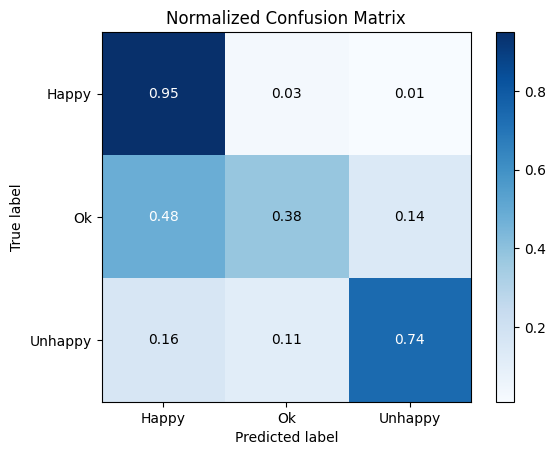

In [26]:
pred_test_lsvm = l.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, pred_test_lsvm, normalize=True)
plt.show()

# Model Testing

In [27]:
# Example reviews to test covering different sentiments
example_reviews = [
    "This product is amazing and I love it!", # Happy
    "I am very disappointed with this product.", # Unhappy
    "It's an okay product, nothing special.", # Ok
    "This is the best thing I have ever bought!", # Happy
    "The product stopped working just a week after I bought it.", # Unhappy
    "this is amazing car."
]

# Using the Linear SVC model for prediction as it had the best training performance
for example_review in example_reviews:
    # Preprocess the example review
    example_features_word = vectorize_word.transform([example_review])
    example_features_char = vectorize_char.transform([example_review])
    example_features = hstack([example_features_char, example_features_word])

    # Predict the sentiment using the Linear SVC model
    predicted_sentiment = l.predict(example_features)

    print(f"{example_review} --> {predicted_sentiment[0]}")

This product is amazing and I love it! --> Happy
I am very disappointed with this product. --> Unhappy
It's an okay product, nothing special. --> Ok
This is the best thing I have ever bought! --> Happy
The product stopped working just a week after I bought it. --> Unhappy
this is amazing car. --> Happy


# Model Comparison

Model Performance Comparison (Training and Test Set):


,Model,Accuracy,Weighted F1-score,Set
0,Logistic Regression,0.948555,0.949579,Training
1,Linear SVC,0.988691,0.988888,Training
0,Logistic Regression,0.901369,0.900667,Test
1,Linear SVC,0.900851,0.900192,Test


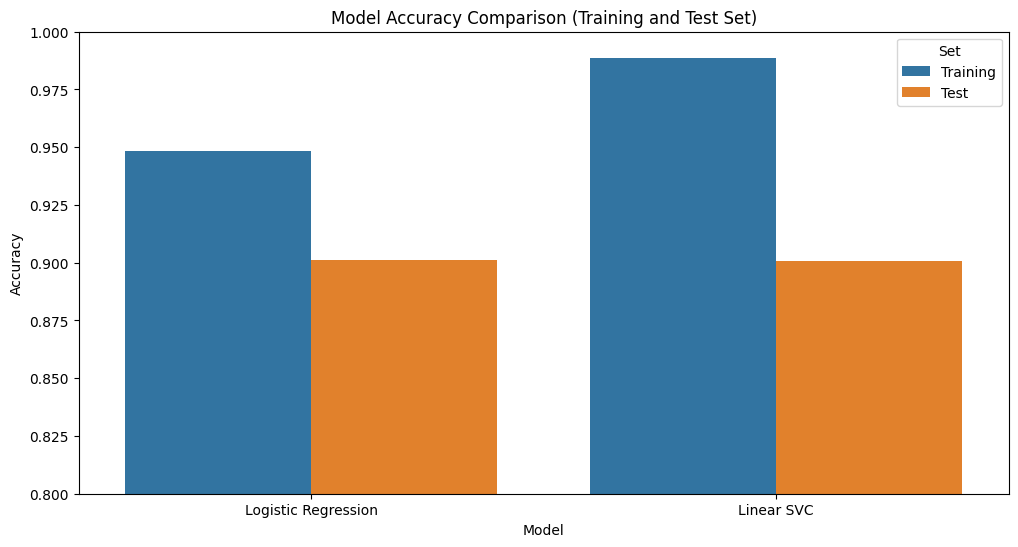

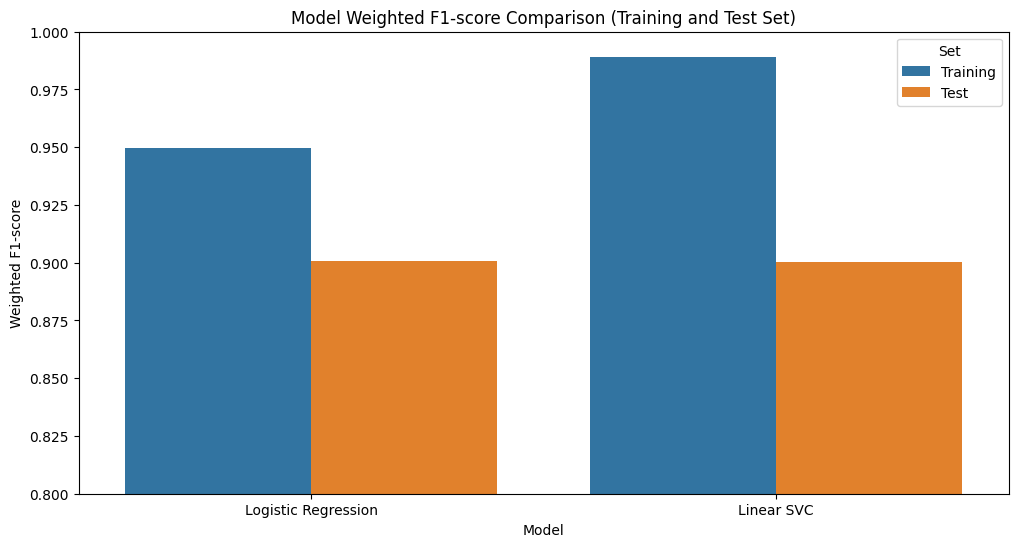

In [28]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate metrics for each model on the training set
accuracy_train_logreg = accuracy_score(y_train, pred_train_logreg)
f1_train_logreg = f1_score(y_train, pred_train_logreg, average='weighted')

# Get the predictions for the Linear SVC model on the training set
pred_train_lsvm = l.predict(X_train)
accuracy_train_lsvm = accuracy_score(y_train, pred_train_lsvm)
f1_train_lsvm = f1_score(y_train, pred_train_lsvm, average='weighted')


# Calculate metrics for each model on the test set
accuracy_test_logreg = accuracy_score(y_test, pred_test_logreg)
f1_test_logreg = f1_score(y_test, pred_test_logreg, average='weighted')

# Get the predictions for the Linear SVC model on the test set
pred_test_lsvm = l.predict(X_test)
accuracy_test_lsvm = accuracy_score(y_test, pred_test_lsvm)
f1_test_lsvm = f1_score(y_test, pred_test_lsvm, average='weighted')


# Create DataFrames to store the metrics
metrics_train_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Linear SVC'],
    'Accuracy': [accuracy_train_logreg, accuracy_train_lsvm],
    'Weighted F1-score': [f1_train_logreg, f1_train_lsvm],
    'Set': 'Training'
})

metrics_test_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Linear SVC'],
    'Accuracy': [accuracy_test_logreg, accuracy_test_lsvm],
    'Weighted F1-score': [f1_test_logreg, f1_test_lsvm],
    'Set': 'Test'
})

metrics_df = pd.concat([metrics_train_df, metrics_test_df])


print("Model Performance Comparison (Training and Test Set):")
display(metrics_df)

# Visualize the accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', hue='Set', data=metrics_df)
plt.title('Model Accuracy Comparison (Training and Test Set)')
plt.ylim(0.8, 1.0) # Set y-axis limits for better visualization of differences
plt.ylabel('Accuracy')
plt.show()

# Visualize the weighted F1-score
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Weighted F1-score', hue='Set', data=metrics_df)
plt.title('Model Weighted F1-score Comparison (Training and Test Set)')
plt.ylim(0.8, 1.0) # Set y-axis limits for better visualization of differences
plt.ylabel('Weighted F1-score')
plt.show()